In [31]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader, Dataset, SubsetRandomSampler
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np

In [0]:
path = f"/content/drive/My Drive/pokemon/dataset"

In [0]:
#we do not apply transformations like Random Horizontal Flip to test data
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     #transforms.RandomCrop(124, padding=4, pad_if_needed=True),
     transforms.RandomResizedCrop(128),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

validation_test_transform = transforms.Compose(
    [transforms.Resize([128, 128]),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [0]:
train_dataset = datasets.ImageFolder(root=path, transform=train_transform)
validation_dataset = datasets.ImageFolder(root=path, transform=validation_test_transform)
test_dataset = datasets.ImageFolder(root=path, transform=validation_test_transform)

In [36]:
dataset = datasets.ImageFolder(path)#, transform=image_transform)
train_size = 0.8
valid_size = 0.1
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
train_split = int(np.floor(train_size * num_train))
val_split = int(np.floor(valid_size * num_train))
test_split = num_train - train_split - val_split
train_idx, valid_idx, test_idx = indices[: train_split], indices[train_split : train_split + val_split], indices[train_split + val_split: ]
len(train_idx), len(valid_idx), len(test_idx)

(524, 65, 66)

In [37]:
print(f"Number of samples in the training set is {len(train_dataset)}, actual sample going to be loaded for training is {len(train_idx)}")
print(f"Number of samples in the validation set is {len(train_dataset)}, actual sample going to be loaded for validation is {len(valid_idx)}")
print(f"Number of samples in the test set is {len(train_dataset)}, actual sample going to be loaded for test is {len(test_idx)}")

Number of samples in the training set is 655, actual sample going to be loaded for training is 524
Number of samples in the validation set is 655, actual sample going to be loaded for validation is 65
Number of samples in the test set is 655, actual sample going to be loaded for test is 66


In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
valid_loader = DataLoader(validation_dataset, batch_size=16, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=16, sampler=test_sampler)

In [39]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

torch.Size([16, 3, 128, 128])

In [40]:
labels

tensor([1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


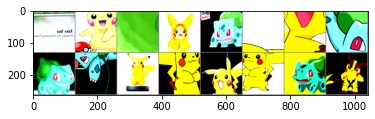

Meowth Pickachu Bulbasaur Pickachu


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ['Bulbasaur', 'Meowth', 'Pickachu']
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Here is some formula to understand about convolutional and pooling layer

In a convolutional neural network, there are 3 main parameters that need to be tweaked to modify the behavior of a convolutional layer. These parameters are filter size, stride and zero padding. The size of the output feature map generated depends on the above 3 important parameters.

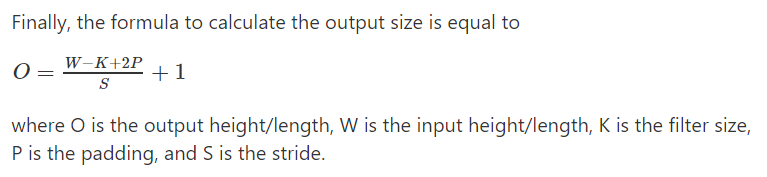


Kernel size will be k * k * previous channel size.

1) In convolutional layer, it reduces kernel sized value to a single value in image(multiplication and addition). Kernels have weights here

2) In pooling layer(max pooling or average pooling) it also reduces kernel sized value to a single value in image. It just takes maximum value from that window in max pooling

In [0]:
class EdgeLayersCNN(nn.Module):
  def __init__(self, num_classes=3):
    super().__init__()
    self.linear1 = nn.Linear(4096, 512)
    self.linear2 = nn.Linear(512, 3)
  
  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    return x

In [0]:
model = models.vgg19(pretrained=True)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.classifier[6] = EdgeLayersCNN()

In [0]:
cuda_availablity = torch.cuda.is_available()

In [0]:
if cuda_availablity == True:
  model.cuda()

In [0]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [0]:
def adjustable_learning_rate(epoch):
  lr = 0.001
  if epoch > 100:
    lr = lr/100
  elif epoch > 60:
    lr = lr/10
  elif epoch > 10:
    lr = lr/2
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [0]:
def eval_model(loader):
  model.eval()
  accu = 0.0
  num_mini_batches = 0.0
  for i, (images, labels) in enumerate(loader):
    if cuda_availablity == True:
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    #Predict classes using images from validation or test.
    outputs = model(images)
    _, prediction = torch.max(outputs.data, 1)
    accu += ((torch.sum(prediction==labels.data).cpu().numpy())/len(prediction))
    num_mini_batches = i
  accu = accu/(num_mini_batches+1)
  return accu

In [50]:
epochs = 10

for epoch in range(epochs):
  model.train()
  train_acc = 0.0
  best_accu = 0.0
  train_loss = 0.0
  num_mini_batches = None
  for i, (images, labels) in enumerate(train_loader):
    #Move images to GPU if cuda is avialable
    if cuda_availablity == True:
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    #Clear accumulated gradients
    optimizer.zero_grad()
    #Predict classes using images from the test set.
    outputs = model(images)
    #Compute the loss function for predicted and actual labels.
    loss = loss_function(outputs, labels)
    #backward propogation
    loss.backward()

    #Adjust parameters according to the computed gradients
    optimizer.step()
    train_loss += loss.cpu().data.numpy().ravel()[0]
    _, prediction = torch.max(outputs.data, 1)
    train_acc += ((torch.sum(prediction==labels.data).cpu().numpy())/len(prediction))
    num_mini_batches = i
  #adjust learning rate
  adjustable_learning_rate(epoch)

  #Average Accuracy
  train_acc = train_acc/(num_mini_batches+1)
  train_loss = train_loss/(num_mini_batches+1)
  
  #Evaluate on the test set
  valid_accu = eval_model(valid_loader)

  if valid_accu > best_accu:
    torch.save(model.state_dict, f"pokemon_pytorch_model.pt")
    best_accu = valid_accu
    print(f"Epoch :{epoch}, Checkpoint Saved, Valid Accu: {valid_accu}")

  print(f"Epoch {epoch}, Train Accuracy: {train_acc} , TrainLoss: {train_loss} , Valid Accuracy: {valid_accu}")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type EdgeLayersCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch :0, Checkpoint Saved, Valid Accu: 0.8625
Epoch 0, Train Accuracy: 0.7695707070707071 , TrainLoss: 0.568773503556396 , Valid Accuracy: 0.8625
Epoch :1, Checkpoint Saved, Valid Accu: 0.9125
Epoch 1, Train Accuracy: 0.86489898989899 , TrainLoss: 0.3410410142757676 , Valid Accuracy: 0.9125
Epoch :2, Checkpoint Saved, Valid Accu: 0.9125
Epoch 2, Train Accuracy: 0.8819444444444445 , TrainLoss: 0.32536164761492703 , Valid Accuracy: 0.9125
Epoch :3, Checkpoint Saved, Valid Accu: 0.925
Epoch 3, Train Accuracy: 0.8838383838383839 , TrainLoss: 0.33009178078535834 , Valid Accuracy: 0.925
Epoch :4, Checkpoint Saved, Valid Accu: 0.7375
Epoch 4, Train Accuracy: 0.8813131313131313 , TrainLoss: 0.31031740321354434 , Valid Accuracy: 0.7375
Epoch :5, Checkpoint Saved, Valid Accu: 0.9
Epoch 5, Train Accuracy: 0.8863636363636364 , TrainLoss: 0.2772471306450439 , Valid Accuracy: 0.9
Epoch :6, Checkpoint Saved, Valid Accu: 0.925
Epoch 6, Train Accuracy: 0.8907828282828283 , TrainLoss: 0.256291312250224

In [58]:
print(f"Test Accuracy: {eval_model(test_loader)}")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Accuracy: 0.925
